In [1]:
library(ggplot2)
library(data.table)
library(forecast)
library(stringr)
library(lubridate)
library(zoo)
library(urca)

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Attaching package: 'lubridate'

The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following object is masked from 'package:base':

    date


Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'urca' was built under R version 3.6.3"

### Introduction

The consumption series is an hourly data from EPİAŞ, which shows realized electricity consumption of Turkey. Suppliers produce electiricty according to the demand of it. Everyday, electricity should be produced enough to supply the consumption but also it shouldn't be produced in excessive amounts to prevent wasting of resources. That is why forecasting the consumption in a data driven way, provides valuable information to the suppliers. In this assignment, hourly data is substracted from the EDİAŞ transparency platform to be analyzed in order to construct a forecasting model. 

In [2]:
consumption <- fread("C:/Users/kaan9/OneDrive/Masaüstü/consumption.csv")
colnames(consumption) <- c("Date","dateTime","value")
consumption <- consumption[,`:=`(value=as.numeric(str_replace_all(value,",",""))*1000,
                                 Date = as.Date(consumption$Date,"%d.%m.%Y"),
                                 dateTime = dmy_hm(paste(Date,dateTime," ")))]

### 1.1) Hourly Consumption

Date,dateTime,value,prediction
2016-03-27,2016-03-27 02:00:00,0,-51.91832


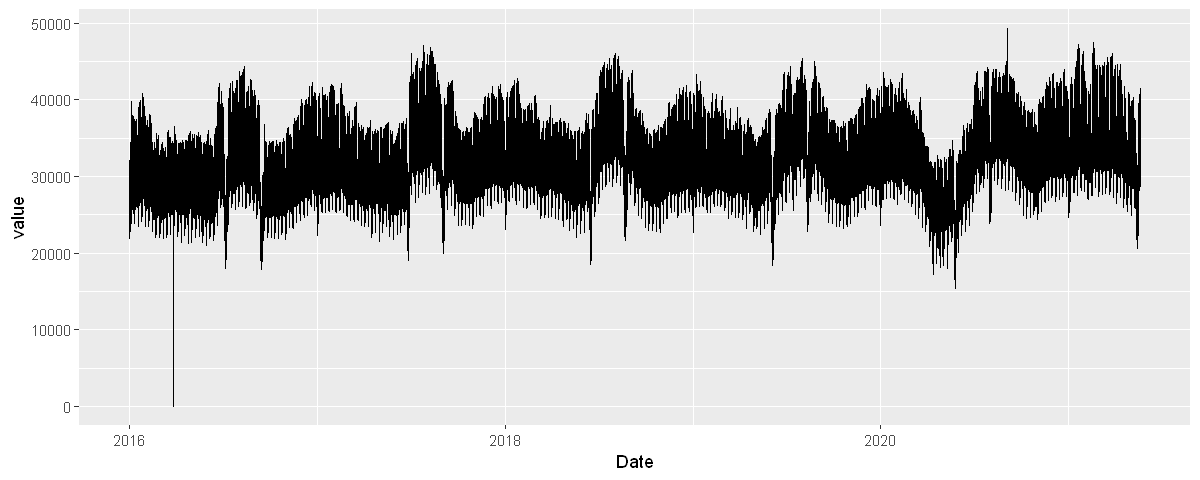

In [50]:
options(repr.plot.width = 10, repr.plot.height = 4)
ggplot(consumption,aes(x=Date,y=value)) + geom_line()
consumption[which.min(consumption$value)]

It could be visually seen that there is some outliers in the data. These might be the special days like holidays. There is some upward trend but the variance looks constant. The seasonality might be exist and the unit root test should be applied to see wheter the series is stationary or not. 

In [4]:
unit_test <- ur.kpss(consumption$value)
summary(unit_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 18 lags. 

Value of test-statistic is: 12.695 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


According to the test results, the consumption series is not stationary but the model should applied on a stationary series. In the first step, trend and seasonlity should be examined.

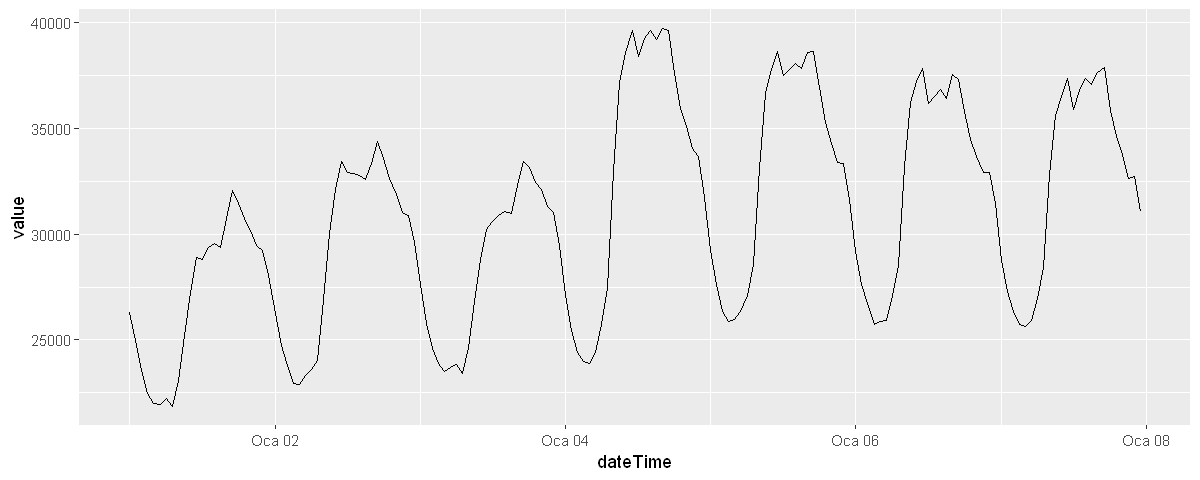

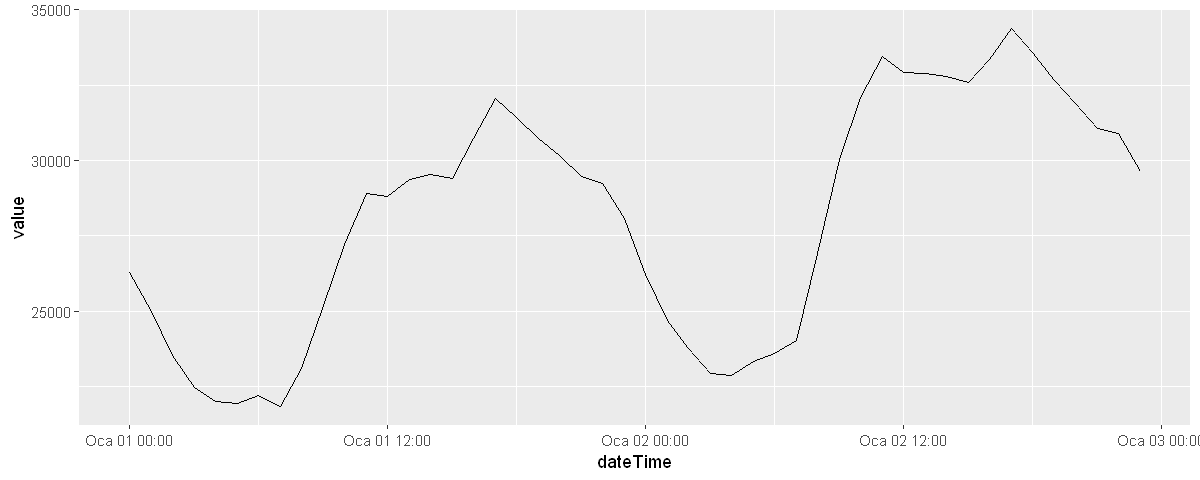

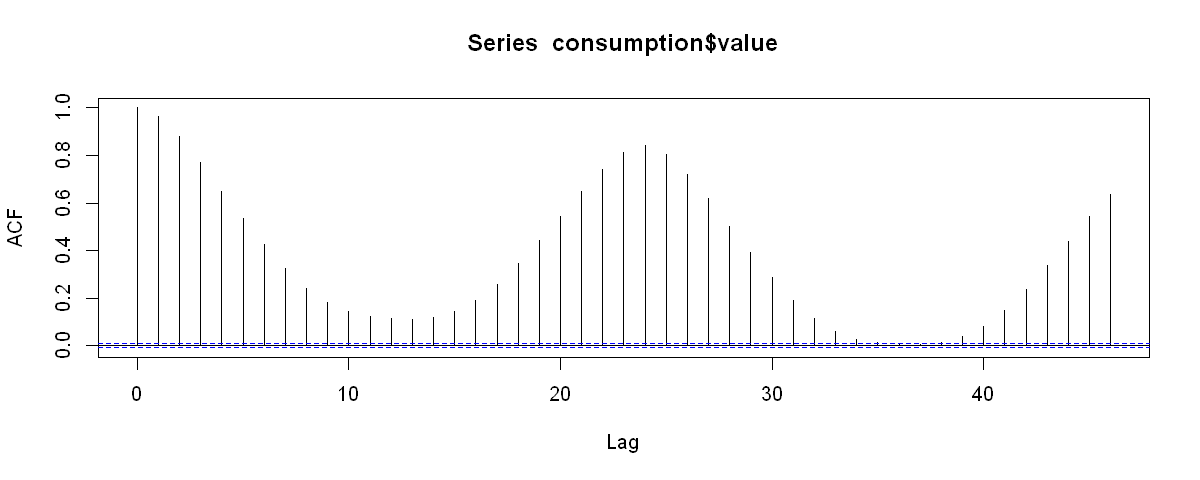

In [5]:
ggplot(consumption[Date>='2016-01-01' & Date<='2016-01-07'],aes(x=dateTime,y=value)) + geom_line()
ggplot(consumption[Date=='2016-01-01' | Date=='2016-01-02'],aes(x=dateTime,y=value)) + geom_line()
acf(consumption$value)

It is obvious that consumption values shows similar patterns in the same hours of different days. Consumptions increases after 7 AM and reaches it's peak at near 5 PM, then it starts decreasing. ACF function's graph has biggest spikes at 0 and 24th lag and also there is some sinus wave pattern on it. It could be said that, there is a 24 hour pattern which is daily seasonality.

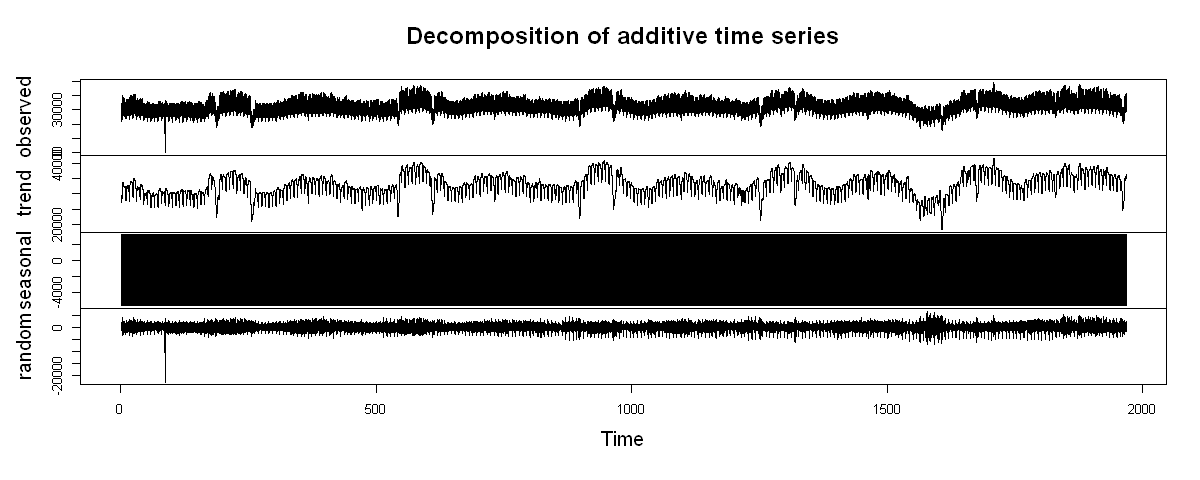

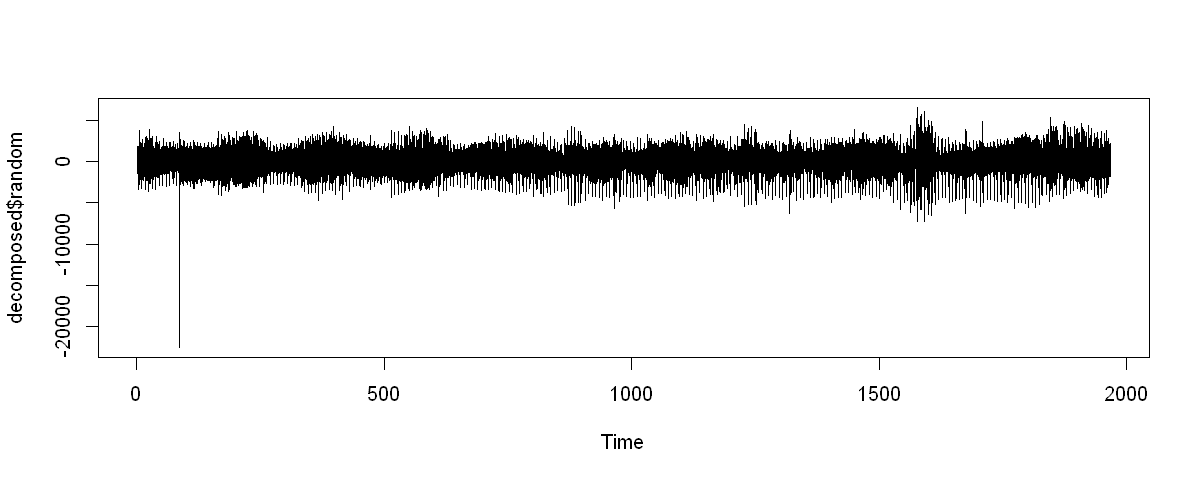

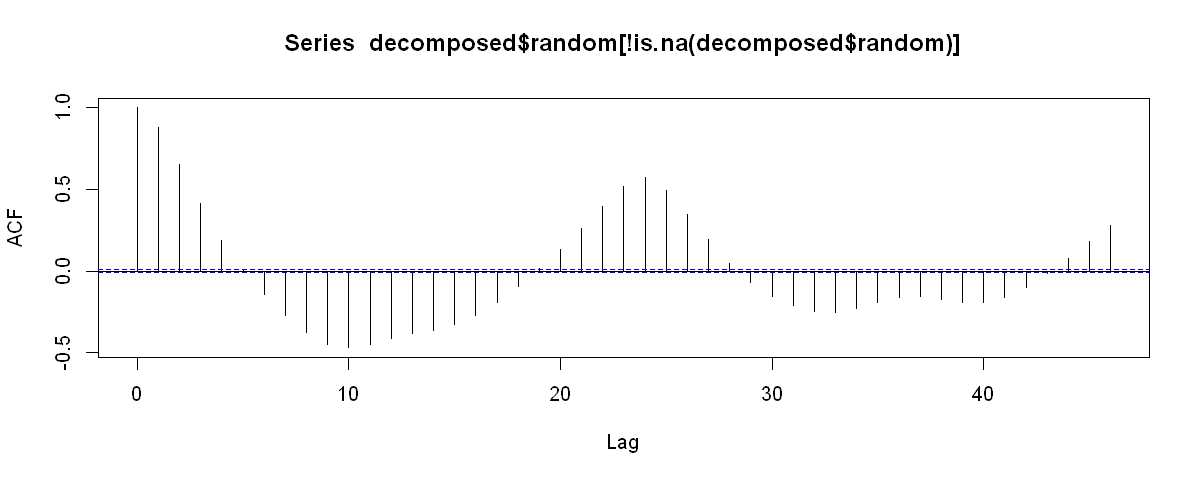

In [6]:
consumption_ts <- ts(consumption$value,freq=24)
decomposed <- decompose(consumption_ts)
plot(decomposed)
plot(decomposed$random)
acf(decomposed$random[!is.na(decomposed$random)])

After the decomposition, data looks more stationary however there is still some outliers. There is a little sinus wave pattern in the ACF function and also is has significant spike at lag 7. It may imply the existance of another seasonality. 

In [7]:
unit_test <- ur.kpss(decomposed$random)
summary(unit_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 18 lags. 

Value of test-statistic is: 3e-04 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


### 1.2) Daily Consumption

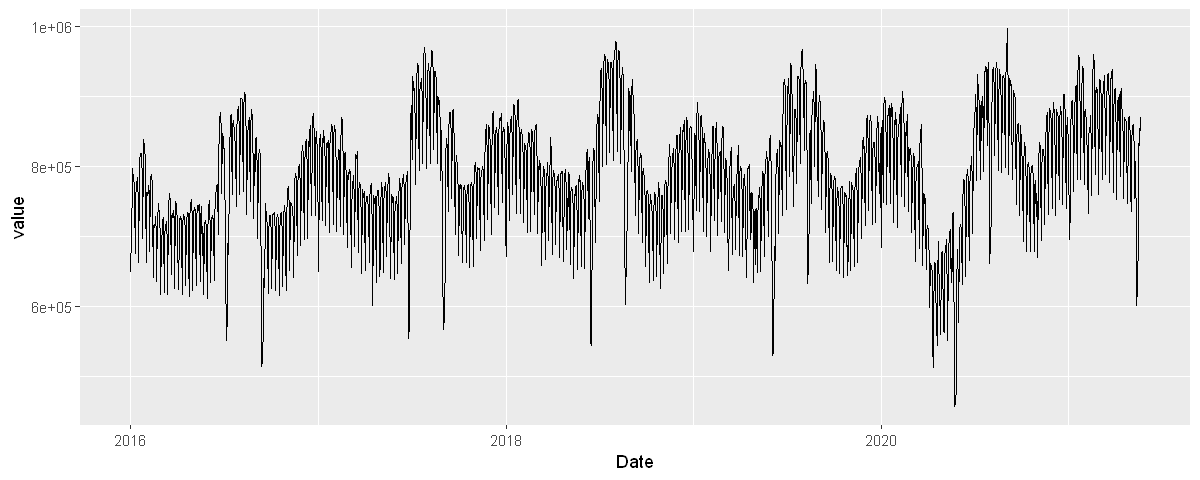

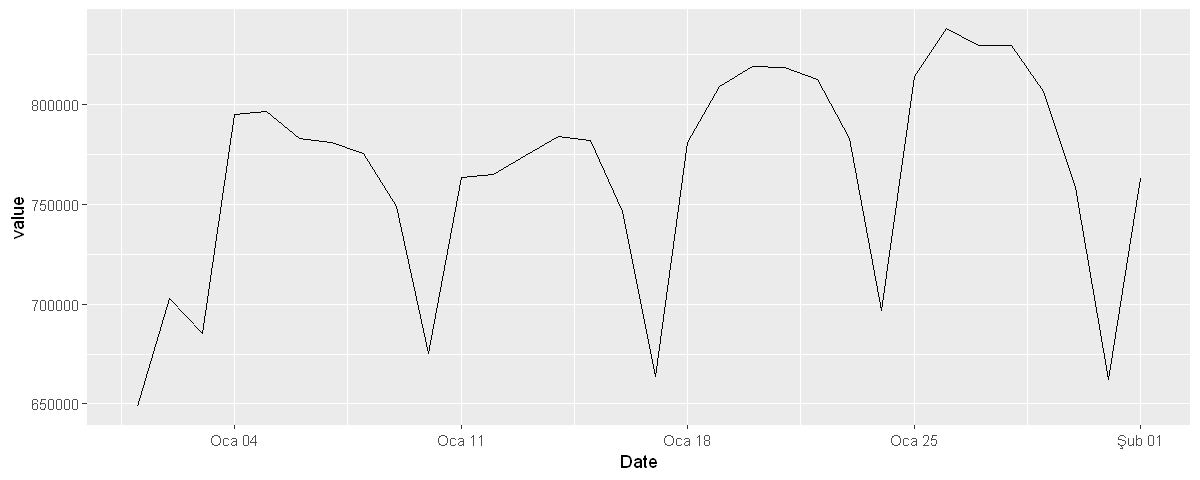

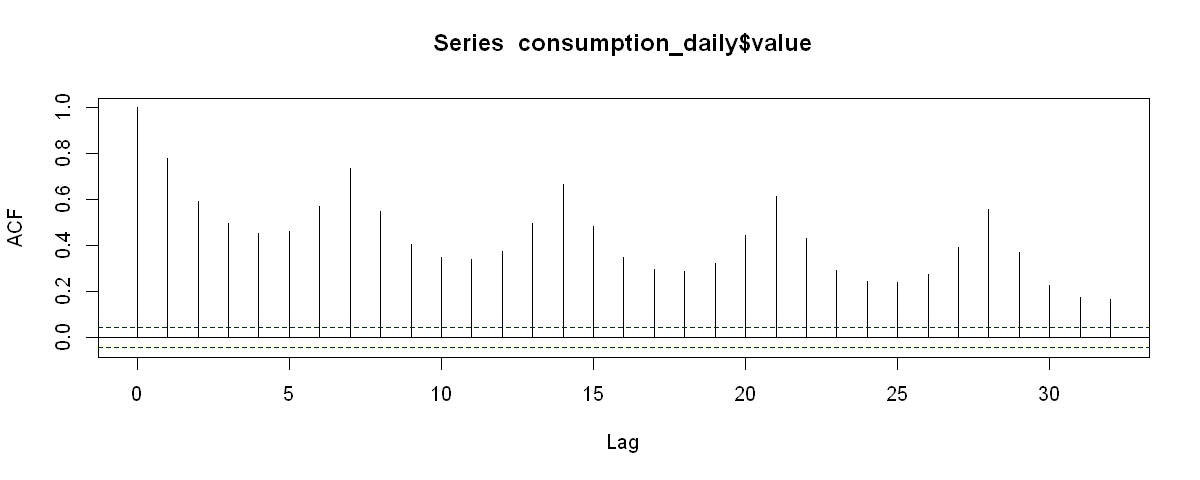

In [8]:
consumption_daily <- consumption[,.(value=sum(value)),by=.(Date)]
ggplot(consumption_daily,aes(x=Date,y=value)) + geom_line()
ggplot(consumption_daily[Date>='2016-01-01' & Date<='2016-02-01'],aes(x=Date,y=value)) + geom_line()
acf(consumption_daily$value)

When the series examined by total daily consumption, it could be seen that consumption increases at mondays, it stays in high levels at the weekdays and decreases at weekends. There is weekly seasonality because there is similar pattern in every 7 days. ACF graph tells is with the big spikes in every 7 lags. So, series could decomposed with 168 hours cycle which means weekly. 

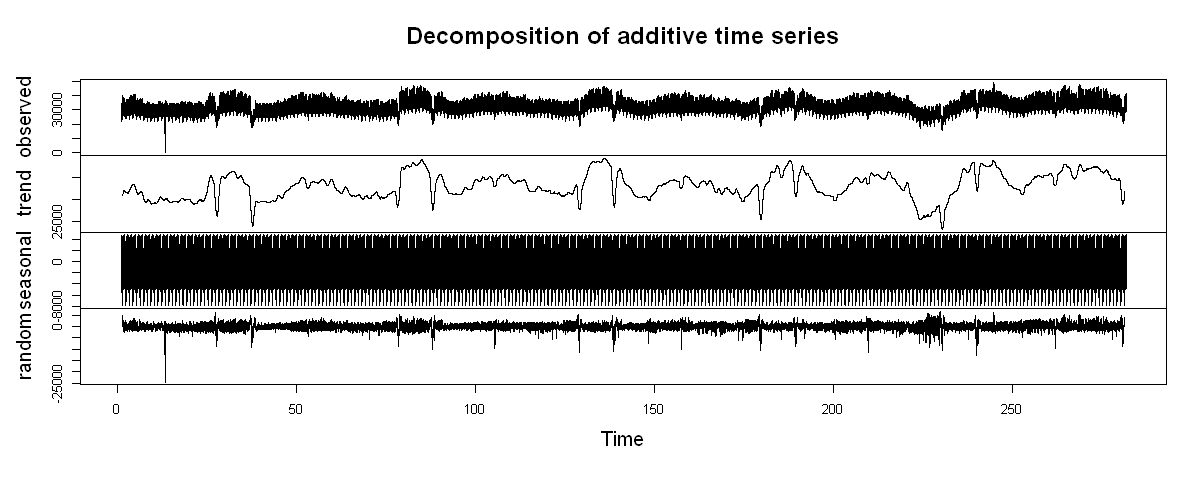

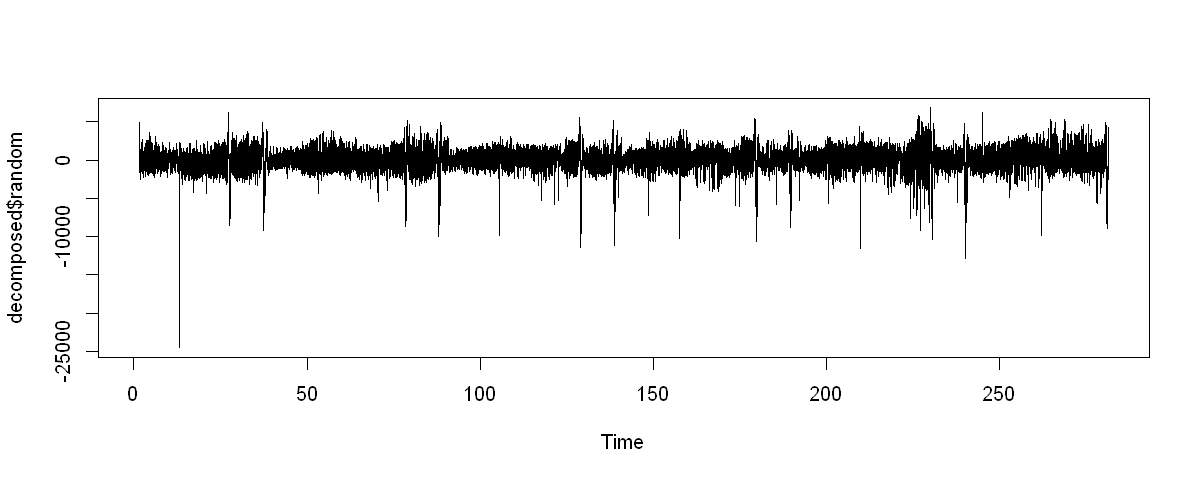

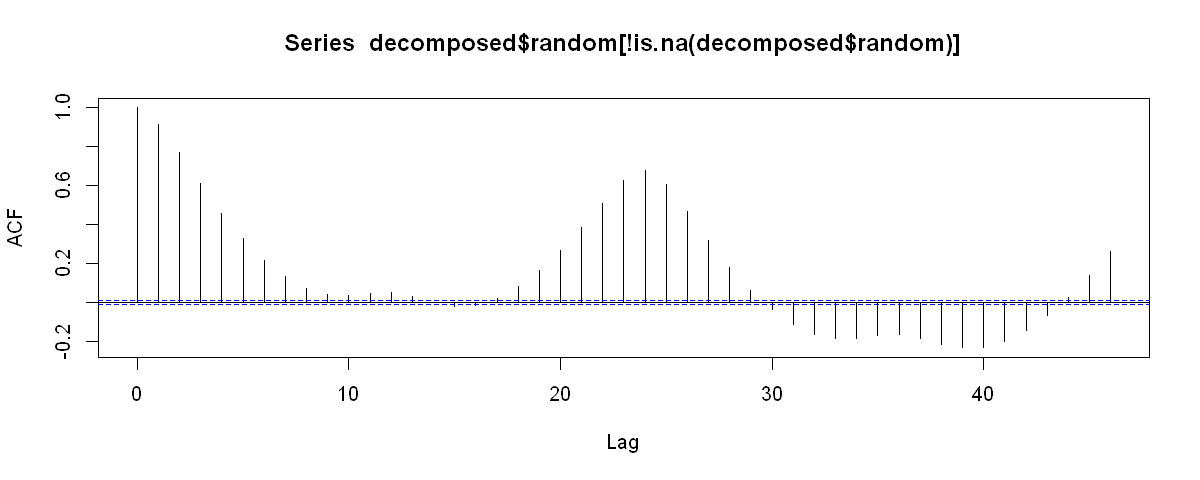

In [9]:
consumption_ts2 <- ts(consumption$value,freq=24*7)
decomposed <- decompose(consumption_ts2)
plot(decomposed)
plot(decomposed$random)
acf(decomposed$random[!is.na(decomposed$random)])

In [10]:
unit_test <- ur.kpss(decomposed$random)
summary(unit_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 18 lags. 

Value of test-statistic is: 0.0042 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


Weekly decomposition provides more stationary series however ACF graph still has some patterns.

### 1.3) Monthly Consumption

Don't know how to automatically pick scale for object of type yearmon. Defaulting to continuous.


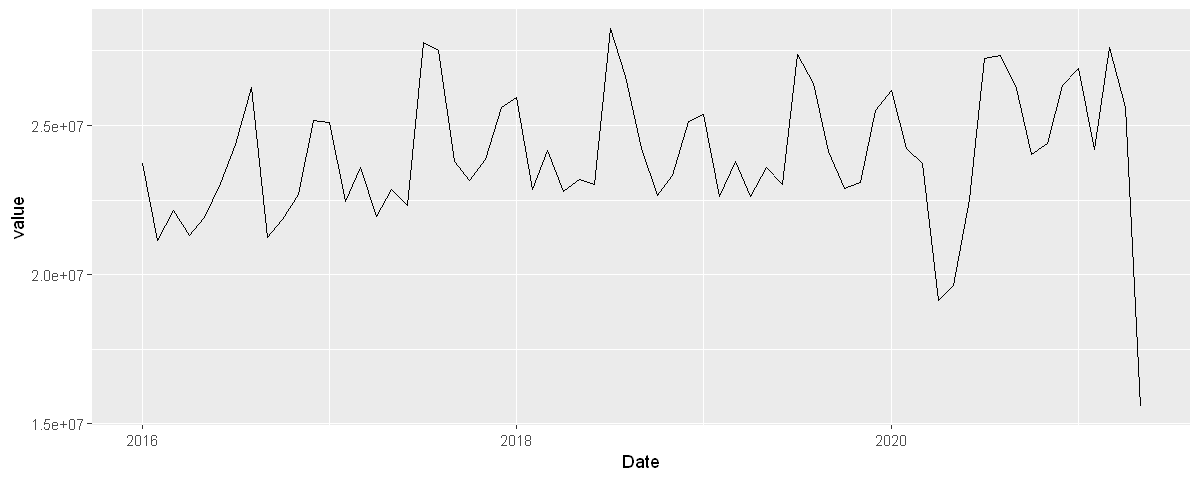

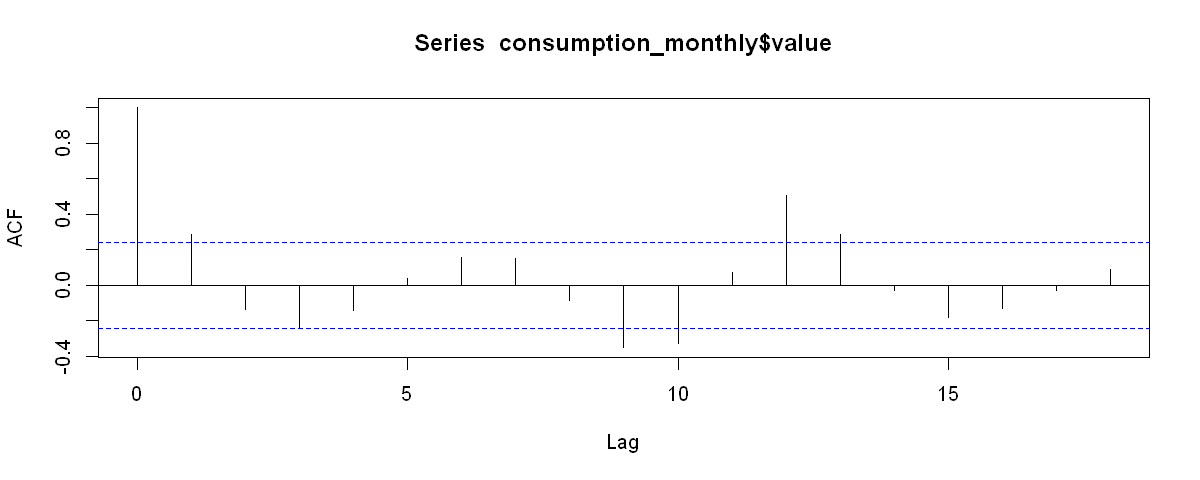

In [11]:
consumption_monthly <- consumption[,.(value=sum(value)),by=.(Date=as.yearmon(Date))]
ggplot(consumption_monthly,aes(x=Date,y=value)) + geom_line()
acf(consumption_monthly$value)

When consumption examined monthly, it could be said that consumption increases in winter and summers while it decreases in autmn and spring. ACF graph also shows big spike at lag 12 which means there might be a yearly seasonality.

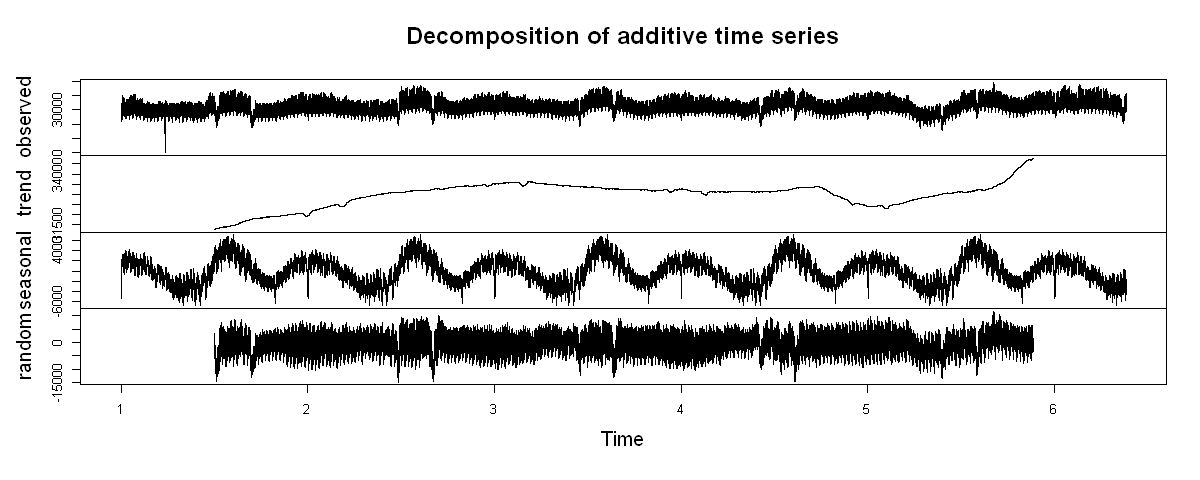

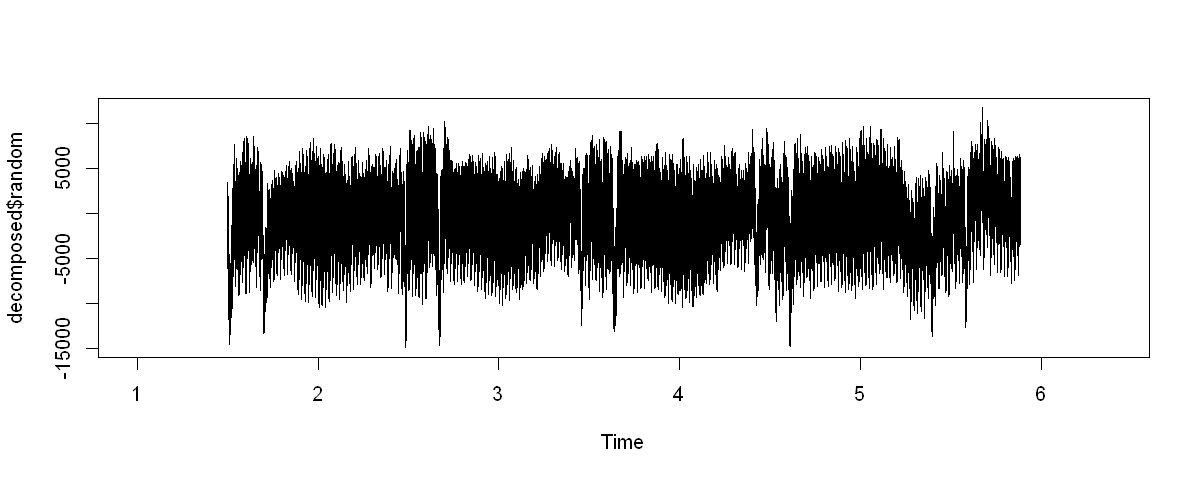

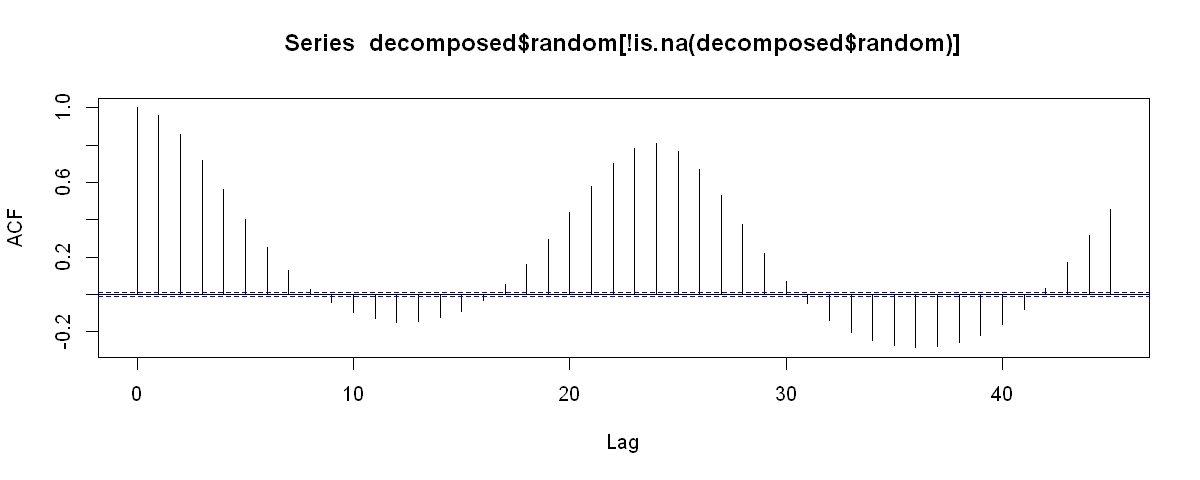

In [80]:
consumption_ts <- ts(consumption$value,freq=24*365.25)
decomposed <- decompose(consumption_ts)
plot(decomposed)
plot(decomposed$random)
acf(decomposed$random[!is.na(decomposed$random)])

In [13]:
unit_test <- ur.kpss(decomposed$random)
summary(unit_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 17 lags. 

Value of test-statistic is: 0.4976 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


Decomposing on a monthly level didn't help to make the series more stationary according to the unit root test. Also, ACF graph tells there is still seasonality left in the data.

### 2) Decomposition on the given seasonality setting

Given setting implies that both the hour and the day of the observation define the seasonality. A multi-seasonal time series object could be used to decompose the data. Since the last 14 days will be the test data, the model will be trained on all observations except last 336 hours.

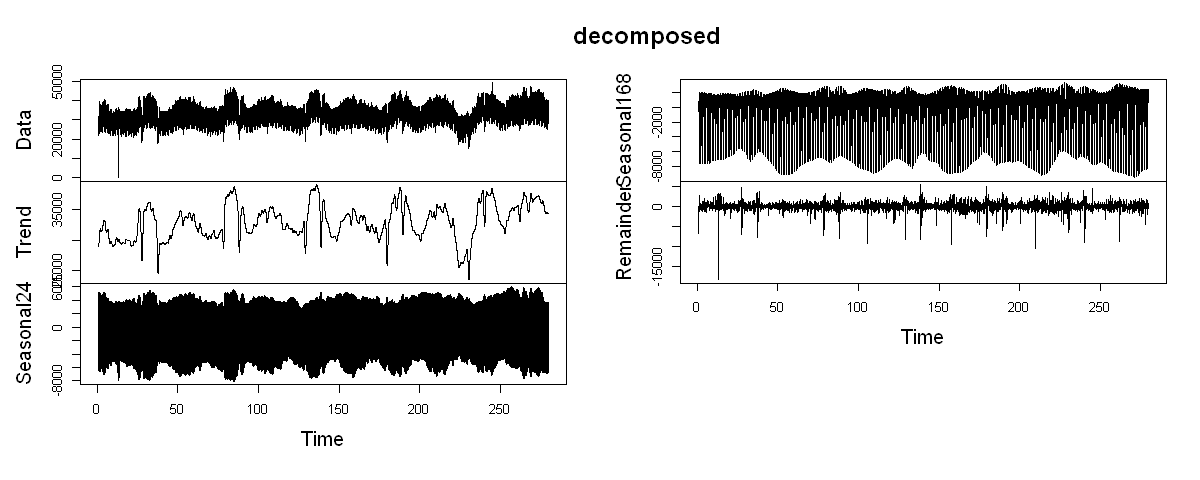

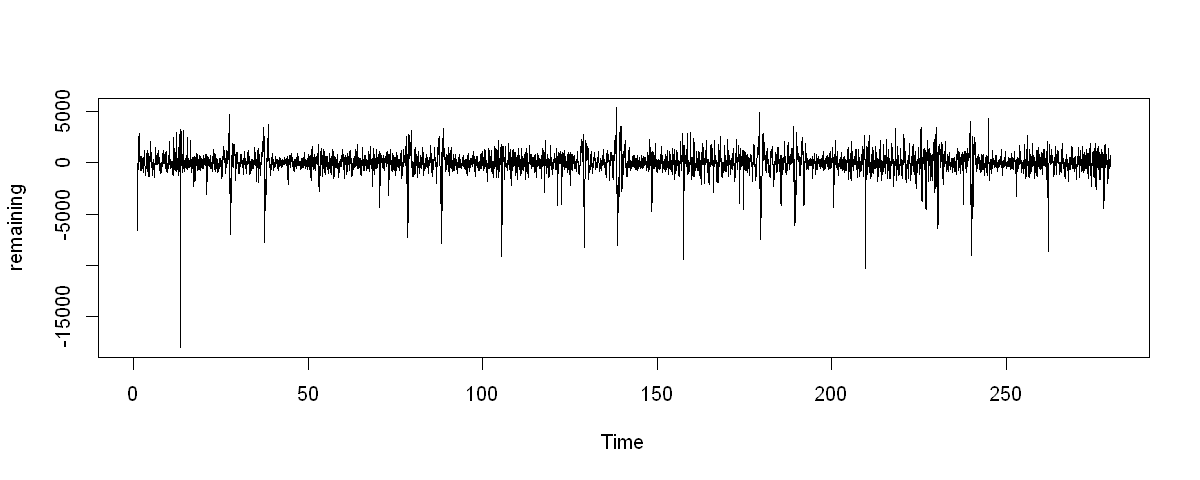

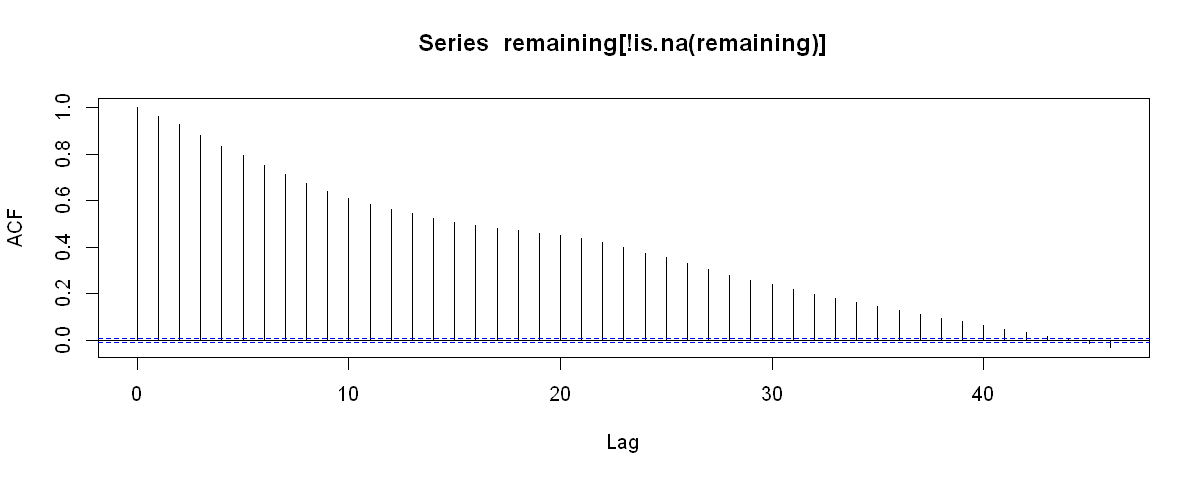

In [85]:
train <- consumption$value[1:(nrow(consumption)-336)]
consumption_ms <- msts(train,seasonal.periods = c(24, 24*7))
decomposed <- mstl(consumption_ms)
remaining <- decomposed[,5]
plot(decomposed)
plot(remaining)
acf(remaining[!is.na(remaining)])

In [84]:
nrow(consumption)

[1] 47208

When the series decomposed to trend and weekly seasonality, it could be said that the remaining looks stationary with constant variance and mean. However, ACF graph shows high correlation between lags. Differencing could be used to solve the problem.

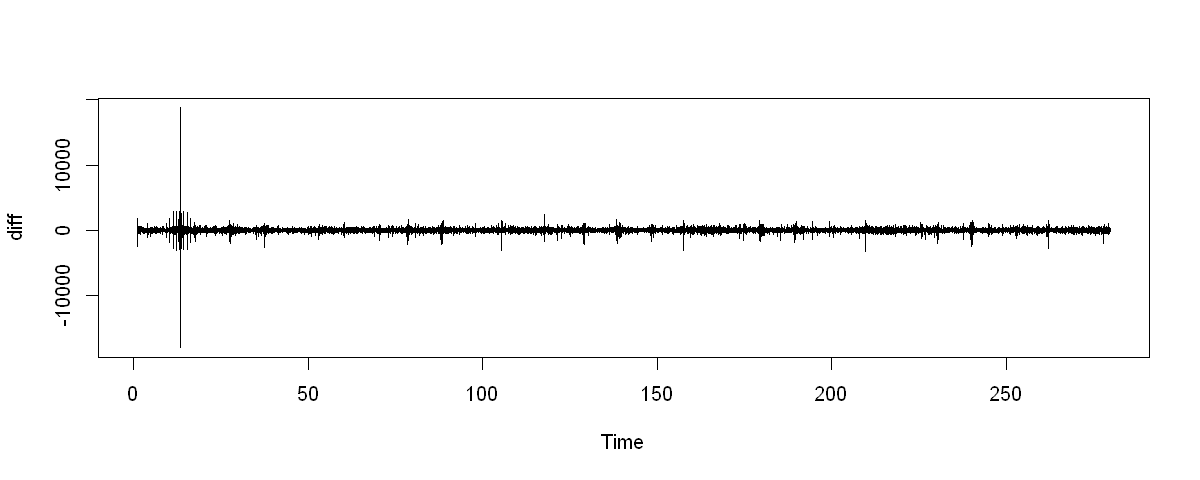

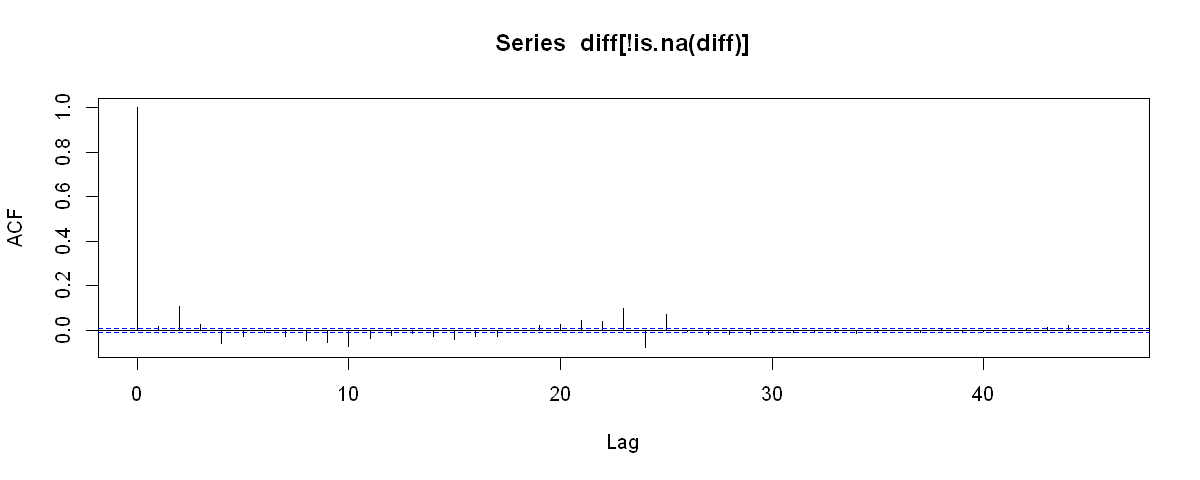

In [86]:
diff <- remaining - shift(remaining,1)
plot(diff)
acf(diff[!is.na(diff)])

In [87]:
unit_test <- ur.kpss(diff)
summary(unit_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 18 lags. 

Value of test-statistic is: 4e-04 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


After differencing, it could be seen that the series is stationary now. ACF graph doesn't show any pattern so the only problem is outliers. The series are ready to construct an ARIMA model.

### 3) The AR Model

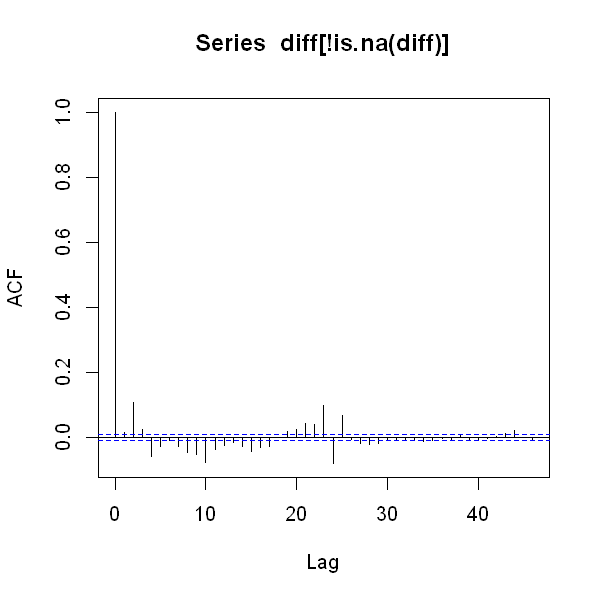

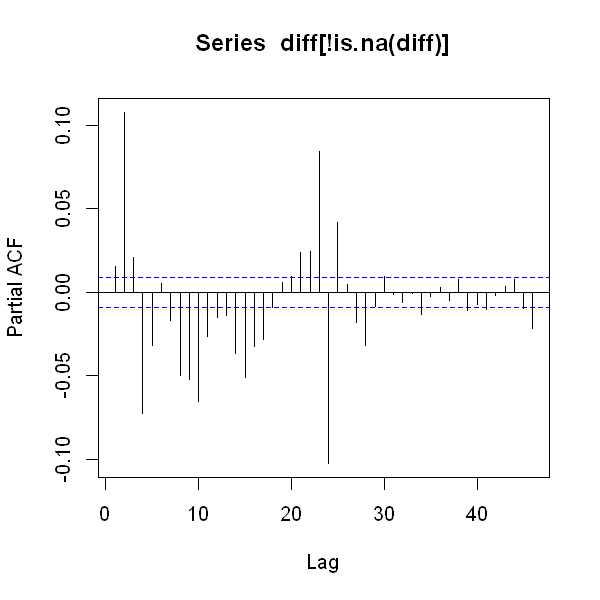

In [88]:
options(repr.plot.width = 5, repr.plot.height = 5)
acf(diff[!is.na(diff)])
pacf(diff[!is.na(diff)])

To construct an AR model, p parameter could be chosen from the lags in the PACF graph. The parameter which gives the lowest AIC should be taken. After the lag 5, spike of the lag 6 is not significant. So, lag 5 could be taken as p parameter.

In [95]:
arima(diff,order=c(5,0,0))


Call:
arima(x = diff, order = c(5, 0, 0))

Coefficients:
         ar1     ar2     ar3      ar4      ar5  intercept
      0.0108  0.1160  0.0255  -0.0722  -0.0317     0.0098
s.e.  0.0046  0.0046  0.0046   0.0046   0.0046     1.1676

sigma^2 estimated as 57856:  log likelihood = -323493.9,  aic = 647001.8

### 4) The MA Model

Again, ACF and PACF graphs should be examined. At the graph of ACF, lag 2 is signifanct while lag 3 is not. So again lag 2 could be taken as the q paramter.

In [96]:
arima(diff,order=c(0,0,2))


Call:
arima(x = diff, order = c(0, 0, 2))

Coefficients:
         ma1     ma2  intercept
      0.0071  0.1237     0.0098
s.e.  0.0046  0.0049     1.2596

sigma^2 estimated as 58151:  log likelihood = -323613.3,  aic = 647234.6

### 5) The ARIMA Model and Forecast

The MA model previously constructed is not better then AR value since it has lower AIC value. Two models could combined to a ARIMA model and its AIC could be compared to others.

In [184]:
model <- Arima(diff,order=c(5,0,2))
model

Warning message in sqrt(diag(x$var.coef)):
"NaNs üretimi"

Series: diff 
ARIMA(5,0,2) with non-zero mean 

Coefficients:
         ar1     ar2     ar3      ar4      ar5     ma1     ma2    mean
      0.0041  0.0582  0.0269  -0.0662  -0.0302  0.0070  0.0583  0.0098
s.e.  0.1533     NaN  0.0179      NaN   0.0140  0.1532     NaN  1.1751

sigma^2 estimated as 57866:  log likelihood=-323493.9
AIC=647005.8   AICc=647005.8   BIC=647084.6

The final ARIMA model has lower AIC than MA model but same with AR. So, this model could be used in the forecast steps.

In [220]:
forecasted <- forecast(model,h=24*14)
prediction <- forecasted$fitted + shift(remaining,1)
prediction <- prediction  + decomposed[,4] + decomposed[,3] + decomposed[,2]
forecasted$mean[1] <- forecasted$mean[1] +  remaining[length(remaining)]
last <- cumsum(forecasted$mean)
last <- last + decomposed[,4][(length(decomposed[,4])-14*24+1):length(decomposed[,4])] +
                          decomposed[,3][(length(decomposed[,3])-14*24+1):(length(decomposed[,3]))] +
                          decomposed[,2][(length(decomposed[,2])-14*24+1):(length(decomposed[,2]))]
prediction <- c(prediction,last)
consumption$prediction <- prediction 

After predictions have been made, shifted values and other components have been added to the fitted values. The graph of predictions and real values of the last year is shown below.

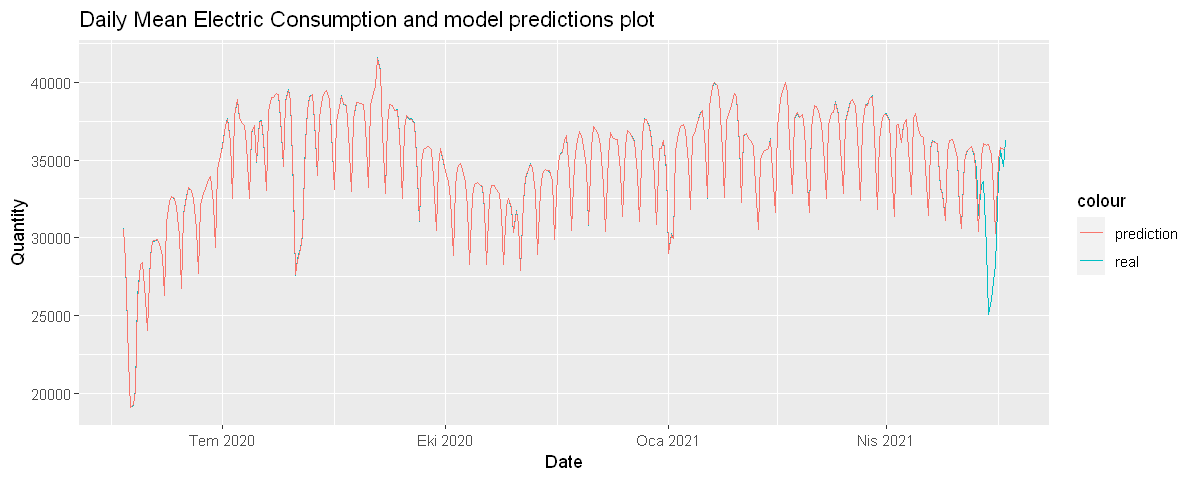

In [217]:
options(repr.plot.width = 10, repr.plot.height = 4)
consumption_daily <- consumption[,.(value=mean(value),prediction=mean(prediction)),by=.(Date)]
ggplot(tail(consumption_daily,365),aes(x=Date)) + 
geom_line(aes(y=value,color='real')) + 
        geom_line(aes(y=prediction,color='prediction')) +
        labs(title= "Daily Mean Electric Consumption and model predictions plot", x= "Date", y="Quantity")

MAPE

In [222]:
sum(abs((tail(consumption_daily$value,15)-tail(consumption_daily$prediction,15))/tail(consumption_daily$value,15)))*100/15

[1] 10.60372

WMAPE

In [224]:
sum(abs(tail(consumption_daily$value,15)-tail(consumption_daily$prediction,15)))/sum(abs(tail(consumption_daily$value,15)))*100

[1] 9.231716

### 6) Conclusion

Turkey's hourly consumption data decomposed to its components then an ARIMA model is constructed. The last 14 day didn't included the model's training set and used as a test data set. The test results gave 10.6 MAPE and 9.23 WMAPE error rates. 